In [ ]:
멀티프로세스

# 기본 설정

In [1]:
import sys
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

# 기본 라이브러리
import os
import json
import shutil

# PyTorch 관련 라이브러리
import torch.utils.data as data
import torch.backends.cudnn as cudnn

# 이미지 변환 관련 라이브러리
from torchvision import transforms

# 데이터 로더 및 모델, 유틸리티 함수 불러오기
from data_loader import get_segmentation_dataset  # 데이터셋 불러오는 함수
from utils.loss import MixSoftmaxCrossEntropyLoss, MixSoftmaxCrossEntropyOHEMLoss  # 손실 함수
from utils.lr_scheduler import LRScheduler  # 학습률 스케줄러
from utils.metric import SegmentationMetric  # 평가 지표

from modules import conv3x3, conv1x1, DWConvBNAct, PWConvBNAct, ConvBNAct, Activation, SegHead
from model_registry import register_model, aux_models

# Python 모듈 경로에 'models' 폴더 추가
models_path = "/home/segmentsafestep/Fast-SCNN-pytorch-master/models"

if models_path not in sys.path:
    sys.path.append(models_path)  # models 폴더 추가
    
# sys.path 확인 (제대로 추가되었는지)
print("Python 경로 목록:")
print("\n".join(sys.path))

train_img_path = "/home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/leftImg8bit/train"
dataset_root = "/home/segmentsafestep/Fast-SCNN-pytorch-master/datasets"

Python 경로 목록:
/home/segmentsafestep/miniconda3/envs/jupyter-env/lib/python39.zip
/home/segmentsafestep/miniconda3/envs/jupyter-env/lib/python3.9
/home/segmentsafestep/miniconda3/envs/jupyter-env/lib/python3.9/lib-dynload

/home/segmentsafestep/miniconda3/envs/jupyter-env/lib/python3.9/site-packages
/home/segmentsafestep/miniconda3/envs/jupyter-env/lib/python3.9/site-packages/IPython/extensions
/home/segmentsafestep/.ipython
/home/segmentsafestep/Fast-SCNN-pytorch-master/models


In [2]:
import torch

# GPU가 가능하면 사용하고, 아니면 CPU 사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("현재 사용 중인 디바이스:", device)
if torch.cuda.is_available():
    print("사용 중인 GPU:", torch.cuda.get_device_name(0))

현재 사용 중인 디바이스: cuda
사용 중인 GPU: NVIDIA L4


# 모델 설정

In [3]:
# BiSeNetV2 모델 정의
@register_model(aux_models)  # 모델을 등록하는 Decorator (사용자 정의 모델 등록을 위한 코드)
class BiSeNetv2(nn.Module):
    def __init__(self, num_class=1, n_channel=3, act_type='relu', use_aux=True):
        super().__init__()
        self.use_aux = use_aux  # 보조 분류(head) 사용 여부 설정 (True일 경우 보조 출력 사용)

        # 상세한 특징을 추출하는 Branch
        self.detail_branch = DetailBranch(n_channel, 128, act_type)

        # 의미론적 특징(Semantic Feature)을 추출하는 Branch
        self.semantic_branch = SemanticBranch(n_channel, 128, num_class, act_type, use_aux)

        # 두 개의 Branch에서 나온 특징을 합치는 Layer
        self.bga_layer = BilateralGuidedAggregationLayer(128, 128, act_type)

        # 최종 Segmentation 결과를 출력하는 Segmentation Head
        self.seg_head = SegHead(128, num_class, act_type)

    def forward(self, x, is_training=False):
        size = x.size()[2:]  # 원본 입력 크기 저장 (업샘플링에 사용)
        x_d = self.detail_branch(x)  # Detail Branch 실행 (미세한 특징 추출)

        # 보조 분류 사용 여부에 따라 처리 방식 결정
        if self.use_aux:
            x_s, aux2, aux3, aux4, aux5 = self.semantic_branch(x)  # Semantic Branch 실행
        else:
            x_s = self.semantic_branch(x)

        x = self.bga_layer(x_d, x_s)  # 두 개의 Branch 출력 합성
        x = self.seg_head(x)  # 최종 Segmentation 결과 출력
        x = F.interpolate(x, size, mode='bilinear', align_corners=True)  # 원본 크기로 업샘플링

        # 보조 분류 사용 여부에 따라 추가 보조 출력 반환
        if self.use_aux and is_training:
            return x, (aux2, aux3, aux4, aux5)
        else:
            return x
        
# Detail Branch: 고해상도 특징을 유지하면서 세부 정보를 추출
class DetailBranch(nn.Sequential):
    def __init__(self, in_channels, out_channels, act_type='relu'):
        super().__init__(
            ConvBNAct(in_channels, 64, 3, 2, act_type=act_type),  # 입력 채널 → 64 채널 변환, 다운샘플링
            ConvBNAct(64, 64, 3, 1, act_type=act_type),  # Conv 연산 (필터 유지)
            ConvBNAct(64, 64, 3, 2, act_type=act_type),  # 다운샘플링
            ConvBNAct(64, 64, 3, 1, act_type=act_type),  # Conv 연산
            ConvBNAct(64, 128, 3, 1, act_type=act_type),  # 채널 확장
            ConvBNAct(128, 128, 3, 2, act_type=act_type),  # 다운샘플링
            ConvBNAct(128, 128, 3, 1, act_type=act_type),  # Conv 연산
            ConvBNAct(128, out_channels, 3, 1, act_type=act_type)  # 최종 출력
        )
        
# Semantic Branch: 저해상도 특징을 추출하면서 의미론적 정보를 학습
class SemanticBranch(nn.Sequential):
    def __init__(self, in_channels, out_channels, num_class, act_type='relu', use_aux=False):
        super().__init__()
        self.use_aux = use_aux  # 보조 출력을 사용할지 여부

        # 첫 번째 단계: 초기 Feature 추출
        self.stage1to2 = StemBlock(in_channels, 16, act_type)

        # 두 번째 단계: 저해상도 특징 추출
        self.stage3 = nn.Sequential(
            GatherExpansionLayer(16, 32, 2, act_type),  # 다운샘플링 (16 → 32 채널)
            GatherExpansionLayer(32, 32, 1, act_type),  # Conv 연산
        )

        self.stage4 = nn.Sequential(
            GatherExpansionLayer(32, 64, 2, act_type),  # 다운샘플링 (32 → 64 채널)
            GatherExpansionLayer(64, 64, 1, act_type),  # Conv 연산
        )

        self.stage5_1to4 = nn.Sequential(
            GatherExpansionLayer(64, 128, 2, act_type),  # 다운샘플링 (64 → 128 채널)
            GatherExpansionLayer(128, 128, 1, act_type),
            GatherExpansionLayer(128, 128, 1, act_type),
            GatherExpansionLayer(128, 128, 1, act_type),
        )

        self.stage5_5 = ContextEmbeddingBlock(128, out_channels, act_type)  # 글로벌 컨텍스트 학습

        # 보조 분류기 정의 (auxiliary segmentation heads)
        if self.use_aux:
            self.seg_head2 = SegHead(16, num_class, act_type)
            self.seg_head3 = SegHead(32, num_class, act_type)
            self.seg_head4 = SegHead(64, num_class, act_type)
            self.seg_head5 = SegHead(128, num_class, act_type)

    def forward(self, x):
        x = self.stage1to2(x)
        if self.use_aux:
            aux2 = self.seg_head2(x)

        x = self.stage3(x)
        if self.use_aux:
            aux3 = self.seg_head3(x)

        x = self.stage4(x)
        if self.use_aux:
            aux4 = self.seg_head4(x)

        x = self.stage5_1to4(x)
        if self.use_aux:
            aux5 = self.seg_head5(x)

        x = self.stage5_5(x)  # 최종 의미론적 정보 추출

        if self.use_aux:
            return x, aux2, aux3, aux4, aux5
        else:
            return x
        
class StemBlock(nn.Module):
    def __init__(self, in_channels, out_channels, act_type='relu'):
        super().__init__()
        self.conv_init = ConvBNAct(in_channels, out_channels, 3, 2, act_type=act_type)
        self.left_branch = nn.Sequential(
                            ConvBNAct(out_channels, out_channels//2, 1, act_type=act_type),
                            ConvBNAct(out_channels//2, out_channels, 3, 2, act_type=act_type)
                    )
        self.right_branch = nn.MaxPool2d(3, 2, 1)
        self.conv_last = ConvBNAct(out_channels*2, out_channels, 3, 1, act_type=act_type)

    def forward(self, x):
        x = self.conv_init(x)
        x_left = self.left_branch(x)
        x_right = self.right_branch(x)
        x = torch.cat([x_left, x_right], dim=1)
        x = self.conv_last(x)

        return x
    
class GatherExpansionLayer(nn.Module):
    def __init__(self, in_channels, out_channels, stride, act_type='relu', expand_ratio=6,):
        super().__init__()
        self.stride = stride
        hid_channels = int(round(in_channels * expand_ratio))

        layers = [ConvBNAct(in_channels, in_channels, 3, act_type=act_type)]

        if stride == 2:
            layers.extend([
                            DWConvBNAct(in_channels, hid_channels, 3, 2, act_type='none'),
                            DWConvBNAct(hid_channels, hid_channels, 3, 1, act_type='none')
                        ])
            self.right_branch = nn.Sequential(
                                    DWConvBNAct(in_channels, in_channels, 3, 2, act_type='none'),
                                    PWConvBNAct(in_channels, out_channels, act_type='none')
                            )
        else:
            layers.append(DWConvBNAct(in_channels, hid_channels, 3, 1, act_type='none'))

        layers.append(PWConvBNAct(hid_channels, out_channels, act_type='none'))
        self.left_branch = nn.Sequential(*layers)
        self.act = Activation(act_type)

    def forward(self, x):
        res = self.left_branch(x)

        if self.stride == 2:
            res = self.right_branch(x) + res
        else:
            res = x + res

        return self.act(res)
    
class ContextEmbeddingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, act_type='relu'):
        super().__init__()
        self.pool = nn.Sequential(
                            nn.AdaptiveAvgPool2d(1),
                            nn.BatchNorm2d(in_channels)
                    )
        self.conv_mid = ConvBNAct(in_channels, in_channels, 1, act_type=act_type)
        self.conv_last = conv3x3(in_channels, out_channels)

    def forward(self, x):
        res = self.pool(x)
        res = self.conv_mid(res)
        x = res + x
        x = self.conv_last(x)

        return x
    
class BilateralGuidedAggregationLayer(nn.Module):
    def __init__(self, in_channels, out_channels, act_type='relu'):
        super().__init__()
        self.detail_high = nn.Sequential(
                                    DWConvBNAct(in_channels, in_channels, 3, act_type=act_type),
                                    conv1x1(in_channels, in_channels)
                        )
        self.detail_low = nn.Sequential(
                                    DWConvBNAct(in_channels, in_channels, 3, 2, act_type=act_type),
                                    nn.AvgPool2d(3, 2, 1)
                        )
        self.semantic_high = nn.Sequential(
                                    ConvBNAct(in_channels, in_channels, 3, act_type=act_type),
                                    nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True),
                                    nn.Sigmoid()
                            )
        self.semantic_low = nn.Sequential(
                                    DWConvBNAct(in_channels, in_channels, 3, act_type=act_type),
                                    conv1x1(in_channels, in_channels),
                                    nn.Sigmoid()
                            )
        self.conv_last = ConvBNAct(in_channels, out_channels, 3, act_type=act_type)

    def forward(self, x_d, x_s):
        x_d_high = self.detail_high(x_d)
        x_d_low = self.detail_low(x_d)

        x_s_high = self.semantic_high(x_s)
        x_s_low = self.semantic_low(x_s)
        x_high = x_d_high * x_s_high
        x_low = x_d_low * x_s_low

        size = x_high.size()[2:]
        x_low = F.interpolate(x_low, size, mode='bilinear', align_corners=True)
        res = x_high + x_low
        res = self.conv_last(res)

        return res

In [4]:
# 클래스 22개
model = BiSeNetv2(num_class=22)

# GPU 자동 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델을 GPU 또는 CPU로 옮기기
model = model.to(device)

## 가중치 파일에 담겨있는 정보 확인하기

In [5]:
# 가중치 파일 경로
pth_file = "/home/segmentsafestep/Fast-SCNN-pytorch-master/weights/bisenetv2-aux.pth"

# 가중치 파일 로드
checkpoint = torch.load(pth_file, map_location="cpu")

# 가중치 파일에 저장된 key 목록 출력
print("가중치 파일에 포함된 키 목록:")
for key in checkpoint.keys():
    print(f"  - {key}")

# 모델 가중치가 저장된 키가 있는지 확인
if "state_dict" in checkpoint:
    print("\n'state_dict' 키가 포함됨 (모델 가중치 포함)")
    state_dict = checkpoint["state_dict"]

    # 가중치 레이어 이름 출력 (최대 10개만)
    print("\n가중치 레이어 목록:")
    for i, (name, param) in enumerate(state_dict.items()):
        if i < 10:  # 10개까지만 출력
            print(f"  - {name}: {param.shape}")
        else:
            print("  ... (더 많은 가중치가 있음)")
            break
else:
    print("\n'state_dict' 키가 없음 (모델 가중치가 저장되지 않은 파일일 수 있음)")

# 체크포인트 파일에 다른 정보(예: 학습률, 에포크 등)가 저장되어 있는지 확인
metadata_keys = [key for key in checkpoint.keys() if key != "state_dict"]
if metadata_keys:
    print("\n추가적인 메타데이터 포함:")
    for key in metadata_keys:
        print(f"  - {key}: {checkpoint[key]}")
else:
    print("\n추가적인 학습 메타데이터 없음 (가중치 정보만 포함됨)")

가중치 파일에 포함된 키 목록:
  - cur_epoch
  - best_score
  - state_dict
  - optimizer
  - scheduler

'state_dict' 키가 포함됨 (모델 가중치 포함)

가중치 레이어 목록:
  - detail_branch.0.0.weight: torch.Size([64, 3, 3, 3])
  - detail_branch.0.1.weight: torch.Size([64])
  - detail_branch.0.1.bias: torch.Size([64])
  - detail_branch.0.1.running_mean: torch.Size([64])
  - detail_branch.0.1.running_var: torch.Size([64])
  - detail_branch.0.1.num_batches_tracked: torch.Size([])
  - detail_branch.1.0.weight: torch.Size([64, 64, 3, 3])
  - detail_branch.1.1.weight: torch.Size([64])
  - detail_branch.1.1.bias: torch.Size([64])
  - detail_branch.1.1.running_mean: torch.Size([64])
  ... (더 많은 가중치가 있음)

추가적인 메타데이터 포함:
  - cur_epoch: 601
  - best_score: 0.7373115420341492
  - optimizer: None
  - scheduler: None


In [6]:
print(model)  # 모델이 정상적으로 선언되었는지 확인

BiSeNetv2(
  (detail_branch): DetailBranch(
    (0): ConvBNAct(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Activation(
        (activation): ReLU()
      )
    )
    (1): ConvBNAct(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Activation(
        (activation): ReLU()
      )
    )
    (2): ConvBNAct(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Activation(
        (activation): ReLU()
      )
    )
    (3): ConvBNAct(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1

---

# 학습

In [7]:
# 모델 및 학습 관련 하이퍼파라미터 설정
args = {
    "model": "BiSeNetv2",  # 사용할 모델 이름
    "dataset": "surface",  # 학습할 데이터셋 (예: Cityscapes)
    "base_size": 1024,  # 입력 이미지 기본 크기
    "crop_size": 768,  # 학습 시 사용할 크롭 크기
    "train_split": "train",  # 학습 데이터셋의 분할 방식

    # 학습 하이퍼파라미터
    "aux": False,  # 보조 손실 사용 여부
    "aux_weight": 0.4,  # 보조 손실 가중치
    "epochs": 10,  # 학습 에폭 수
    "start_epoch": 0,  # 학습 시작 에폭
    "batch_size": 8,  # 배치 크기를 바꿈
    "lr": 1e-2,  # 학습률
    "momentum": 0.9,  # 모멘텀
    "weight_decay": 1e-4,  # 가중치 감쇠 (L2 정규화)

    # 체크포인트 저장 위치
    "resume": False,  # 기존 모델 체크포인트 (사용하지 않음)
    "save_folder": "./weights",  # 모델 가중치 저장 경로

    # 평가 및 검증 설정
    "eval": False,  # 평가 모드 여부
    "no_val": True,  # 검증 생략 여부
}

# GPU 사용 여부 설정
print(device := torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
cudnn.benchmark = True  # GPU 연산 최적화
args["device"] = device  # 학습에 사용할 디바이스 저장

cuda:0


In [8]:
# 이미지 전처리 변환 설정
input_transform = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 Tensor로 변환
    transforms.Normalize([0.3257, 0.3690, 0.3223], [0.2112, 0.2148, 0.2115]),  # 이미지 정규화
])

# 데이터셋 로드 (학습 및 검증)
data_kwargs = {"transform": input_transform, "base_size": args["base_size"], "crop_size": args["crop_size"]}
train_dataset = get_segmentation_dataset(args["dataset"], split=args["train_split"], mode="train", root=dataset_root, **data_kwargs)
val_dataset = get_segmentation_dataset(args["dataset"], split="val", mode="val", root=dataset_root, **data_kwargs)

# DataLoader 생성 (데이터 배치 단위로 로딩)
train_loader = data.DataLoader(dataset=train_dataset, batch_size=args["batch_size"], shuffle=True, num_workers=4 # 이거 수정해봐
                               , drop_last=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=1, shuffle=False)

# 모델을 GPU 또는 CPU로 이동
dev_mod = model.to(args["device"])

cannot find the mask or image: /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/leftImg8bit/Train/alley/MP_SEL_SUR_045448.jpg /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/gtFine/Train/alley/mp_sel_sur_045448.png
cannot find the mask or image: /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/leftImg8bit/Train/alley/MP_SEL_SUR_045451.jpg /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/gtFine/Train/alley/mp_sel_sur_045451.png
cannot find the mask or image: /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/leftImg8bit/Train/alley/MP_SEL_SUR_045466.jpg /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/gtFine/Train/alley/mp_sel_sur_045466.png
cannot find the mask or image: /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/leftImg8bit/Train/alley/MP_SEL_SUR_045472.jpg /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/gtFine/Train/alley/mp_sel

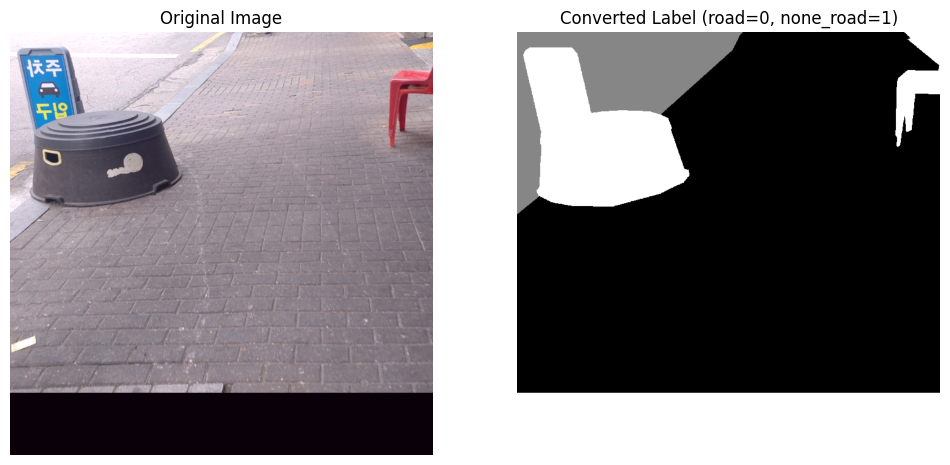

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# 샘플 데이터 가져오기
image, target = train_dataset[0]  # 첫 번째 샘플 데이터

# 텐서를 NumPy 배열로 변환 (CPU로 이동 후 변환)
image_np = image.permute(1, 2, 0).cpu().numpy()  # [C, H, W] → [H, W, C] 변환
image_np = (image_np * 0.2148) + 0.3690  # 정규화 해제 (평균 + 표준편차 곱하기)
image_np = np.clip(image_np, 0, 1)  # 값 범위 조정

target_np = target.cpu().numpy()  # 라벨 데이터 변환

# 원본 이미지와 변환된 라벨을 나란히 출력
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 원본 이미지 표시
axes[0].imshow(image_np)
axes[0].set_title("Original Image")
axes[0].axis("off")

# 변환된 라벨 표시
axes[1].imshow(target_np, cmap="gray")  # 0(검은색), 1(흰색)
axes[1].set_title("Converted Label (road=0, none_road=1)")
axes[1].axis("off")

plt.show()

# 체크포인트

In [32]:
# 손실 함수 설정 (OHEM Loss 사용)
criterion = MixSoftmaxCrossEntropyLoss(aux=args["aux"], aux_weight=args["aux_weight"], ignore_label=-1).to(args["device"])

# 옵티마이저 (SGD 사용)
optimizer = torch.optim.SGD(model.parameters(), lr=args["lr"], momentum=args["momentum"], weight_decay=args["weight_decay"])

# 학습률 스케줄러 설정 (poly decay 사용)
lr_scheduler = LRScheduler(mode="poly", base_lr=args["lr"], nepochs=args["epochs"],
                           iters_per_epoch=len(train_loader), power=0.9)

# 평가 지표 (mIoU 등)
metric = SegmentationMetric(train_dataset.num_class)

# 최고 성능 저장을 위한 변수
best_pred = 0.0

In [37]:
def train():
    global best_pred  # 최고 성능 비교를 위한 전역 변수 사용
    cur_iters = 0  # 현재 반복 횟수
    start_time = time.time()  # 학습 시작 시간

    # 저장할 폴더 생성 (없으면 새로 만듦)
    os.makedirs(args["save_folder"], exist_ok=True)

    # 히스토리 저장용 딕셔너리 초기화
    history = {"epoch": [], "loss": [], "lr": []}

    # 체크포인트 불러오기 (resume=True일 때)
    if args["resume"]:
        if os.path.exists(chk_pnt_path):  # 가중치 파일이 있는지 확인
            print(f"이전 학습 가중치 불러오는 중: {chk_pnt_path}")
            checkpoint = torch.load(chk_pnt_path, map_location=args["device"])
            # model.load_state_dict(checkpoint["state_dict"])  # 모델 가중치 로드
            checkpoint_state = {
                k: v for k, v in checkpoint["state_dict"].items()
                if not k.startswith("seg_head") and not k.startswith("semantic_branch.seg_head")
            }

            # 기존 19개 클래스 가중치를 2개 클래스 모델에 로드 (strict=False 필수)
            model.load_state_dict(checkpoint["state_dict"], strict=False)

            start_epoch = checkpoint.get("epoch", -1) + 1
            print(f"학습을 {start_epoch}번째 에포크부터 이어서 진행합니다.")
        else:
            print("지정된 체크포인트 파일을 찾을 수 없습니다. 처음부터 학습을 시작합니다.")
            start_epoch = args["start_epoch"]
    else:
        start_epoch = args["start_epoch"]

    for epoch in range(start_epoch, args["epochs"]):
        model.train()
        start_time = time.time()

        epoch_loss = 0.0

        for i, (images, targets) in enumerate(train_loader):
            cur_lr = lr_scheduler(cur_iters)  # 현재 학습률 설정
            for param_group in optimizer.param_groups:
                param_group["lr"] = cur_lr  # 옵티마이저에 학습률 적용

            # 데이터를 GPU/CPU로 이동
            images, targets = images.to(args["device"]), targets.to(args["device"])

            # 모델 예측 및 손실 계산
            outputs = model(images)
            loss = criterion((outputs,), targets)

            # 역전파 및 최적화 수행
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()  # 손실 누적
            cur_iters += 1  # 반복 횟수 증가
            if cur_iters % 10 == 0:  # 100회마다 로그 출력
                print(f"Epoch [{epoch}/{args['epochs']}], Step [{i}/{len(train_loader)}], Loss: {loss.item():.4f}")

        end_time = time.time()  # 에폭 종료 시간 기록
        epoch_time = end_time - start_time  # 소요 시간 계산
        print(f"Epoch {epoch} 완료! 소요 시간: {epoch_time:.2f} 초")

        # 히스토리 저장
        avg_loss = epoch_loss / len(train_loader)
        history["epoch"].append(epoch)
        history["loss"].append(avg_loss)
        history["lr"].append(cur_lr)

        # 5의 배수 에폭일 때만 저장
        if epoch % 10 == 0:
            save_path = os.path.join(args["save_folder"], f"model_smpl_city{epoch}.pth")
            torch.save({"epoch": epoch, "state_dict": model.state_dict()}, save_path)
            print(f"모델 가중치 저장됨: {save_path}")

        # 검증 수행
        if not args["no_val"]:
            validation(epoch)

    # 학습 히스토리 저장
    history_path = os.path.join(args["save_folder"], "train_history_smpl_city.json")
    with open(history_path, "w") as f:
        json.dump(history, f)
    print(f"학습 히스토리 저장 완료: {history_path}")

In [38]:
def validation(epoch):
    global best_pred
    model.eval()
    metric.reset()

    import time
    val_start_time = time.time()  # 검증 시작 시간

    for i, (image, target) in enumerate(val_loader):
        image = image.to(args["device"])
        with torch.no_grad():
            outputs = (model(image),)

        pred = torch.argmax(outputs[0], 1).cpu().data.numpy()
        metric.update(pred, target.numpy())

    pixAcc, mIoU = metric.get()
    print(f"Epoch {epoch}, Validation Pixel Acc: {pixAcc:.3f}, mIoU: {mIoU:.3f}")

    new_pred = (pixAcc + mIoU) / 2
    if new_pred > best_pred:
        best_pred = new_pred

    val_end_time = time.time()
    val_duration = val_end_time - val_start_time  # 검증 소요 시간
    print(f" - 검증 소요 시간: {val_duration:.2f} 초")

    return mIoU

In [ ]:
train()

Epoch [0/10], Step [9/2882], Loss: 0.8625
Epoch [0/10], Step [19/2882], Loss: 0.6944
Epoch [0/10], Step [29/2882], Loss: 0.6239
Epoch [0/10], Step [39/2882], Loss: 1.2108
Epoch [0/10], Step [49/2882], Loss: 1.3298
Epoch [0/10], Step [59/2882], Loss: 2.3391
Epoch [0/10], Step [69/2882], Loss: 1.1751
Epoch [0/10], Step [79/2882], Loss: 0.6307
Epoch [0/10], Step [89/2882], Loss: 1.3594
Epoch [0/10], Step [99/2882], Loss: 0.8266
Epoch [0/10], Step [109/2882], Loss: 1.7052
Epoch [0/10], Step [119/2882], Loss: 1.1867
Epoch [0/10], Step [129/2882], Loss: 0.5903
Epoch [0/10], Step [139/2882], Loss: 1.6450
Epoch [0/10], Step [149/2882], Loss: 1.0263
Epoch [0/10], Step [159/2882], Loss: 1.0112
Epoch [0/10], Step [169/2882], Loss: 0.9868
Epoch [0/10], Step [179/2882], Loss: 1.5506
Epoch [0/10], Step [189/2882], Loss: 1.4258
Epoch [0/10], Step [199/2882], Loss: 1.3792
Epoch [0/10], Step [209/2882], Loss: 0.8159
Epoch [0/10], Step [219/2882], Loss: 0.8753
Epoch [0/10], Step [229/2882], Loss: 1.0935

In [19]:
for i, (image, target) in enumerate(val_loader):
    image = image.to(args["device"])
    
    model.eval()  # 모델을 평가 모드로 설정 (BatchNorm 문제 해결)

    with torch.no_grad():
        output = model(image)  # 리스트에 저장하지 않고 바로 사용
        output = output.argmax(dim=1).cpu().numpy()  # 필요하면 바로 NumPy로 변환

In [20]:
out = outputs[0][0]

# out = F.interpolate(out, size=org_size, align_corners=False, mode='bilinear')
print(out.shape)
out = out.argmax(dim=1)
print(out.shape)

# visualize
out = out.squeeze().detach().cpu().numpy()
pred = palette[out] # 앞서 컬러 팔레트는 랜덤으로 세팅


NameError: name 'outputs' is not defined

In [21]:
import matplotlib.pyplot as plt

plt.imshow(pred)  # 세그멘테이션 결과 이미지 출력
plt.axis("off")  # 축 제거 (선택 사항)
plt.show()

NameError: name 'pred' is not defined

In [ ]:
# Cityscapes 19개 클래스 정의
CITYSCAPES_CLASSES = [
    "road", "sidewalk", "building", "wall", "fence", "pole", "traffic light",
    "traffic sign", "vegetation", "terrain", "sky", "person", "rider", "car",
    "truck", "bus", "train", "motorcycle", "bicycle"
]

# Cityscapes 클래스별 RGB 색상
CITYSCAPES_COLORS = {
    "road": (128, 64, 128), "sidewalk": (244, 35, 232), "building": (70, 70, 70),
    "wall": (102, 102, 156), "fence": (190, 153, 153), "pole": (153, 153, 153),
    "traffic light": (250, 170, 30), "traffic sign": (220, 220, 0), "vegetation": (107, 142, 35),
    "terrain": (152, 251, 152), "sky": (70, 130, 180), "person": (220, 20, 60),
    "rider": (255, 0, 0), "car": (0, 0, 142), "truck": (0, 0, 70), "bus": (0, 60, 100),
    "train": (0, 80, 100), "motorcycle": (0, 0, 230), "bicycle": (119, 11, 32)
}

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# 예측된 결과를 정수 클래스 ID로 변환
out = outputs[0][0].argmax(dim=1).cpu().numpy()

# 예측된 클래스 ID 중 실제로 등장한 클래스 찾기
unique_class_ids = np.unique(out)  # 예측된 클래스 ID
detected_classes = [CITYSCAPES_CLASSES[i] for i in unique_class_ids]  # 클래스 이름 매칭

# 클래스 ID를 색상 팔레트로 변환
pred = np.zeros((*out.shape, 3), dtype=np.uint8)  # RGB 이미지 형태 생성
for class_id in unique_class_ids:
    pred[out == class_id] = CITYSCAPES_COLORS[CITYSCAPES_CLASSES[class_id]]

# 불필요한 차원 제거 (Matplotlib이 올바르게 인식하도록)
pred = np.squeeze(pred)  # (1, H, W, 3) → (H, W, 3)으로 변경

# 시각화 (클래스별 색상 범례 추가)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 클래스 범례 출력
axes[0].imshow(pred)  # 수정된 `pred`를 사용
axes[0].set_title("Segmentation Result")
axes[0].axis("off")

# 클래스별 색상 범례 추가
patches = [mpatches.Patch(color=np.array(CITYSCAPES_COLORS[class_name]) / 255.0, label=class_name)
           for class_name in detected_classes]
axes[1].legend(handles=patches, loc="center", fontsize="small", title="Classes")
axes[1].axis("off")

plt.tight_layout()
plt.show()

NameError: name 'outputs' is not defined

---

# miou 확인하기

In [15]:
# 기본 라이브러리
import os
import torch
import torch.utils.data as data
from data_loader import get_segmentation_dataset  # 데이터셋 로드 함수
from utils.metric import SegmentationMetric  # 평가 지표

In [22]:
# 설정 (Jupyter Notebook 환경에 맞게 변경)
args = {
    "dataset": "citys",  # 사용할 데이터셋 (Cityscapes)
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),  # GPU/CPU 설정
    "batch_size": 1,  # 평가 시 배치 크기
    "num_workers": 0,  # DataLoader의 worker 개수 (메모리 문제 방지 위해 0으로 설정)
    "weight_path": "/home/segmentsafestep/Fast-SCNN-pytorch-master/weights/model_2class_5.pth"  # 저장된 가중치 경로
}

In [23]:
# 가중치 파일 확인
if not os.path.exists(args["weight_path"]):
    raise FileNotFoundError(f"가중치 파일이 존재하지 않습니다: {args['weight_path']}")

# 이미지 전처리 설정
input_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([.485, .456, .406], [.229, .224, .225]),
])

In [24]:
# 검증 데이터셋 로드 (Cityscapes val set)
val_dataset = get_segmentation_dataset(args["dataset"], split="val", mode="testval", transform=input_transform, root="/home/segmentsafestep/Fast-SCNN-pytorch-master/datasets")
val_loader = data.DataLoader(
    dataset=val_dataset,
    batch_size=args["batch_size"],
    shuffle=False,
    num_workers=args["num_workers"]
)

# 모델 및 가중치 로드
# model = BiSeNetv2(num_class=val_dataset.num_class).to(args["device"])  # 모델 생성

# 저장된 가중치 파일 로드
checkpoint = torch.load(args["weight_path"], map_location=args["device"])

# 가중치 파일에 state_dict가 포함되어 있으면, 모델 가중치만 추출하여 로드
if "state_dict" in checkpoint:
    model.load_state_dict(checkpoint["state_dict"])  # state_dict만 로드
else:
    model.load_state_dict(checkpoint)  # 이미 순수한 가중치 파일이면 그대로 로드

model.eval()  # 모델을 평가 모드로 설정
print("모델 및 가중치 로드 완료!")

# 평가 지표 설정 (mIoU 및 픽셀 정확도)
metric = SegmentationMetric(val_dataset.num_class)

Found 500 images in /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/citys/leftImg8bit/val
모델 및 가중치 로드 완료!


In [25]:
# 검증 수행 및 mIoU 계산
print("검증 데이터셋 평가 중...")
with torch.no_grad():
    for i, (image, label) in enumerate(val_loader):
        image = image.to(args["device"])
        label = label.cpu().numpy().squeeze()  # GPU -> CPU 후 불필요한 차원 제거

        # 모델 예측 수행
        outputs = model(image)

        # 모델 출력이 (C, W)로 잘못 나오는 경우, 올바르게 변환
        if len(outputs.shape) == 3:  # (C, H, W) 형태라면 batch 차원이 없음 -> 추가
            outputs = outputs.unsqueeze(0)  # (1, C, H, W) 형태로 변환
        elif len(outputs.shape) == 2:  # (C, W) 형태라면 차원 재배열 필요
            outputs = outputs.view(1, outputs.shape[0], 1, outputs.shape[1])  # (1, C, 1, W)로 변환
        
        # 예측 결과 계산
        pred = torch.argmax(outputs, dim=1).cpu().numpy().squeeze()  # (H, W) 형태로 변환
        
        # 평가 지표 업데이트
        metric.update(pred, label)

        # 10개마다 중간 결과 출력
        if (i + 1) % 10 == 0:
            pixAcc, mIoU = metric.get()
            print(f"Sample {i+1}: Pixel Accuracy = {pixAcc * 100:.2f}%, mIoU = {mIoU * 100:.2f}%")

# 최종 평가 결과 출력
final_pixAcc, final_mIoU = metric.get()
print("\n최종 평가 결과")
print(f"Pixel Accuracy: {final_pixAcc * 100:.2f}%")
print(f"Mean IoU (mIoU): {final_mIoU * 100:.2f}%")

검증 데이터셋 평가 중...
Sample 10: Pixel Accuracy = 40.09%, mIoU = 8.79%
Sample 20: Pixel Accuracy = 38.77%, mIoU = 8.36%
Sample 30: Pixel Accuracy = 38.20%, mIoU = 9.09%


KeyboardInterrupt: 

## 가중치 파일에 담겨있는 정보 확인하기

In [24]:
import torch

# 가중치 파일 경로
pth_file = "/aiffel/aiffel/aiffel project model training/Fast-SCNN-pytorch-master/weights/bisenetv2-aux.pth"

# 가중치 파일 로드
checkpoint = torch.load(pth_file, map_location="cpu")

# 가중치 파일에 저장된 key 목록 출력
print("가중치 파일에 포함된 키 목록:")
for key in checkpoint.keys():
    print(f"  - {key}")

# 모델 가중치가 저장된 키가 있는지 확인
if "state_dict" in checkpoint:
    print("\n'state_dict' 키가 포함됨 (모델 가중치 포함)")
    state_dict = checkpoint["state_dict"]

    # 가중치 레이어 이름 출력 (최대 10개만)
    print("\n가중치 레이어 목록:")
    for i, (name, param) in enumerate(state_dict.items()):
        if i < 10:  # 10개까지만 출력
            print(f"  - {name}: {param.shape}")
        else:
            print("  ... (더 많은 가중치가 있음)")
            break
else:
    print("\n'state_dict' 키가 없음 (모델 가중치가 저장되지 않은 파일일 수 있음)")

# 체크포인트 파일에 다른 정보(예: 학습률, 에포크 등)가 저장되어 있는지 확인
metadata_keys = [key for key in checkpoint.keys() if key != "state_dict"]
if metadata_keys:
    print("\n추가적인 메타데이터 포함:")
    for key in metadata_keys:
        print(f"  - {key}: {checkpoint[key]}")
else:
    print("\n추가적인 학습 메타데이터 없음 (가중치 정보만 포함됨)")

FileNotFoundError: [Errno 2] No such file or directory: '/aiffel/aiffel/aiffel project model training/Fast-SCNN-pytorch-master/weights/bisenetv2-aux.pth'

# 이미지 테스트